# [CODiT](https://github.com/jeremy-large/CODiT/blob/master/README.md):
## Agent-Based Methods; Focused Vaccination; B.1.617.2
27 May 2021

### Jeremy Large
#### @UniofOxford @OxfordEconDept @StHughsCollege


With thanks to CODiT's co-creators:
* Nicholas Beale FIMA, Sciteb Ltd
* Justin Jia, Sciteb Ltd
* Paul Scruby
* Leo Foord-Kelcey
* Dustin Foley

.. and gratefully acknowledging Mark Birkin and colleagues, University of Leeds, as well as Leeds City Council, for many helpful comments.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 6]

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

##  Overview

1. Briefly present CODiT; design choices

1. Focused vaccination; a thought experiment about Leeds

1. Conclusion

##  Covid Opensource Digital Twin project (CODiT)

*agent-based* method.

*population* of up to 1M+ making decisions whether to **isolate**, get **tested**, divulge **contacts**, etc.  

compare detailed *policies*

*motivation*: many geographies could benefit from a *focused-systems* approach to suppressing C19. 

* inevitably oversimplifies, 
* needs constant refinement, 
* but we believe that it does give insight

a. A *Model* with a *fixed contact network*

   * each person/node has a fixed valency
   * approximate Digital Twin for a community such as a city, 
   * randomizing where necessary after accessing publicly available data.

b. A *Simulator* of the progress of C19, as impeded by 

   * various policies (eg on testing, tracing, isolation, vaccination)
   * competing variants

c. A *Looper* which allows many runs to be taken to assess 
* the stochasticity of the results and 
* the impact of varying parameters of interest.

### Model

1). A model [population](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city.py#L17), 
stratified by age, who
* react to [relevant symptoms](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/covid.py#L39) 
due to the wild C19, its variants, and to non-C19, and 
* [pass-on C19 to contacts](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/person.py#L78) on a realistic timescale.

2). Fixed network of physical contacts consisting of
* [Households](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city_config/typical_households.py#L8) (aided by OpenStreetMap's 300,000+ records of homes in e.g. Leeds)
* [Study- / work-places](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city.py#L123)
* [School classrooms](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city.py#L156)
* [Care homes](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city.py#L118)
* [Residential buildings/blocks](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city.py#L38)
* ...

* [Ephemeral contact/ brushing past](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/population/networks/city.py#L34)

3). Estimates of compliance by the public with health measures such as the current **Test/Trace/Isolate** system, 
built around a [scaffold of interpretable parameters](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/config.py)

4). [Modelled tests](https://github.com/jeremy-large/CODiT/blob/master/lib/codit/society/test.py) (PCR, lateral flow…) with finite capacity where backlogs can develop

5). As ever, prominent shortcomings. All fixable. Currently:
* single-dose vaccination
* monthly 'vaccination days'
* lockdown-easing is heuristic - having consulted COMIX
* no school holidays
* we would very much value expert input on calibrations and parameter settings
* ...

## Code

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population']

In [5]:
# Suggested first cut:
LOCKDOWN_CFG = dict(classrooms=0.66,         # 66% of classrooms are closed
                    workplaces=0.66,         # 66% of workplaces are closed
                    ephemeral_contact=0.0)   # there's no 'brushing-past' strangers

In [6]:
# We assume that Covid survivors, and the vaccinated, 
# have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is squared for the indian variant (and 80% squared is 64%)

In [7]:
pop = CityPopulation(POPULATION_SIZE, 
                     Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, 
                     lockdown_config=LOCKDOWN_CFG)

2021-05-24 19:11:21.915 INFO     Building a set of 317255 households from which to build a population
2021-05-24 19:12:23.907 INFO     305931 households of mean size 2.59
2021-05-24 19:12:27.879 INFO     139765 buildings of mean size 5.67
2021-05-24 19:13:03.527 INFO     1991 classrooms of mean size 29.39
2021-05-24 19:13:03.896 INFO     117 care_homes of mean size 104.74
2021-05-24 19:13:04.872 INFO     94506 workplaces of mean size 5.59
2021-05-24 19:13:07.535 INFO     66.0% of workplaces closed by lockdown, leaving 33968 open, of average Income Decile 4.87 (and st dev 3.13).
2021-05-24 19:13:07.714 INFO     66.0% of classrooms closed by lockdown, leaving 712 open, of average Income Decile 4.40 (and st dev 3.07).
2021-05-24 19:13:07.753 INFO     Adding 340728 permanent contact groups
2021-05-24 19:13:07.754 INFO     Adding 0 ephemeral contact pairs
2021-05-24 19:13:08.715 INFO     Adding 239682 contacts each within one of the 139765 buildings (contact density of 0.75)


In [8]:
SOCIETY_CFG = dict(
    DAILY_TEST_CAPACITY_PER_HEAD=0.01,     # enough PCR tests for 1% of the population per day ...
    PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.25   # ... however only 25% of symptomatic people come forward
)

soc = UKSociety(config=SOCIETY_CFG)

### Create 2 variants

In [9]:
from codit.disease import Covid

kent_variant = Covid(name="B.1.1.7")
indian_variant = Covid(name="B.1.617.2")

### 'Burn in' a simulation experiment

In [10]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
_ = o_burnin.simulate()

2021-05-24 19:13:43.880 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0180
2021-05-24 19:16:15.750 INFO     Day 30, prop infected is 0.14, prop infectious is 0.0229


### Run a simulation experiment for January and February 2021

* prepare the population, somewhat, for seeding a variant in April

In [11]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

In [12]:
o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()

2021-05-24 19:16:53.716 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0223
2021-05-24 19:20:36.685 INFO     Day 51, prop infected is 0.20, prop infectious is 0.0034
2021-05-24 19:21:08.313 INFO     Day 60, prop infected is 0.20, prop infectious is 0.0023


### 2021 began with a precipitous decline in incidence

2021-05-24 19:21:10.321 INFO      Realized R0 of early infections is 0.97
2021-05-24 19:21:10.321 INFO      20.5 percent of the population was infected during the epidemic


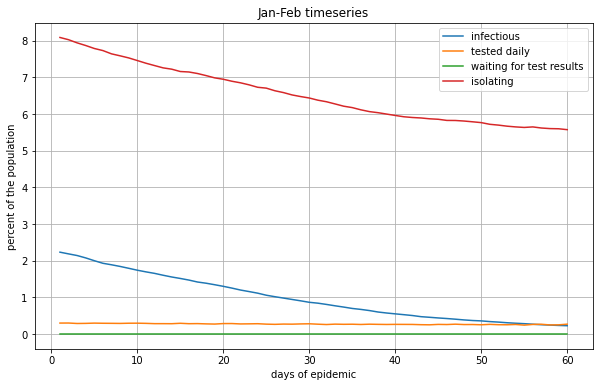

In [13]:
o_Jan_Feb.recorder.plot(title="Jan-Feb timeseries")

### We can map incidence by subregions
* here we look at city-wards in Leeds

In [44]:
r = o_Jan_Feb.recorder.components[-1]

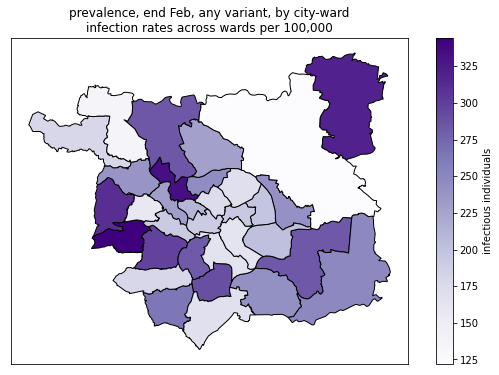

In [45]:
r.map_incidence(r.infectious, 
                title='prevalence, end Feb, any variant, by city-ward', 
                end_date=True, per_hundred_k=True)

In [16]:
JF_results = o_Jan_Feb.recorder.components[-1]
SIX_WEEKS = 5 * 7

### Distribution of rates across the city cohered with true data
* ground truth data not included here

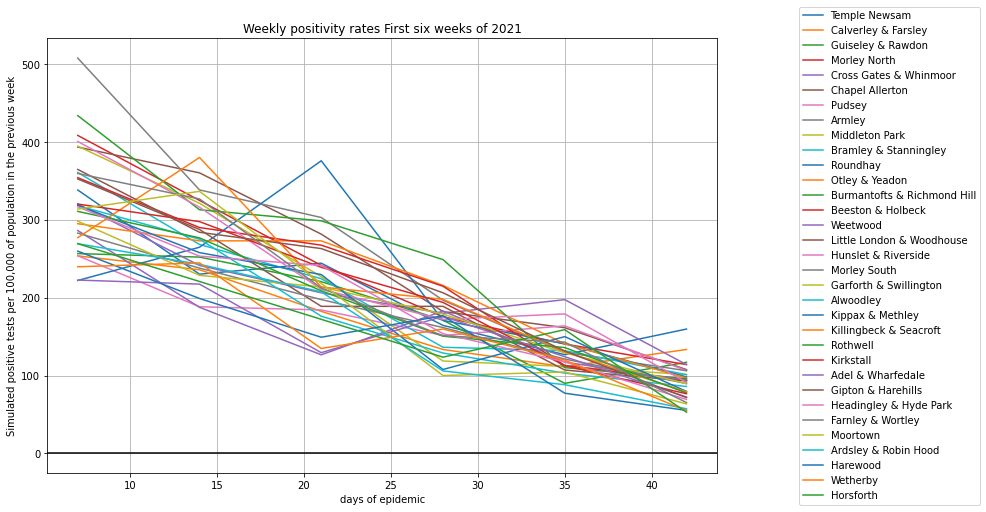

In [17]:
JF_results.plot_weekly_positivity(SIX_WEEKS, title='First six weeks of 2021')

### March 
1. Open classrooms
2. People now 'brush past' on average 0.3 others randomly per day 
    * (loosely following COMIX)
3. Vaccinate the over 60s - 'instant' single-dose vaccination
4. Add lateral flow testing

In [18]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

2021-05-24 19:21:14.743 INFO     66.0% of workplaces closed by lockdown, leaving 33952 open, of average Income Decile 4.87 (and st dev 3.14).
2021-05-24 19:21:14.956 INFO     0.0% of classrooms closed by lockdown, leaving 1646 open, of average Income Decile 4.79 (and st dev 3.09).
2021-05-24 19:21:14.993 INFO     Adding 341646 permanent contact groups
2021-05-24 19:21:15.305 INFO     Adding 118971 ephemeral contact pairs
2021-05-24 19:21:16.205 INFO     Adding 239720 contacts each within one of the 139765 buildings (contact density of 0.75)


In [19]:
for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

In [20]:
from codit.society.lateral import LateralFlowUK
lat_flow_soc = LateralFlowUK(config=SOCIETY_CFG)

2021-05-24 19:21:25.475 INFO     The city has 20x the number of lateral flow tests available, as PCRs


2021-05-24 19:22:03.870 INFO     Setting mass testing valency/degree limit to 21
2021-05-24 19:22:12.272 INFO     Day 1, prop infected is 0.20, prop infectious is 0.0021
2021-05-24 19:30:47.462 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0015
2021-05-24 19:30:48.839 INFO      Realized R0 of early infections is 1.00
2021-05-24 19:30:48.840 INFO      21.1 percent of the population was infected during the epidemic


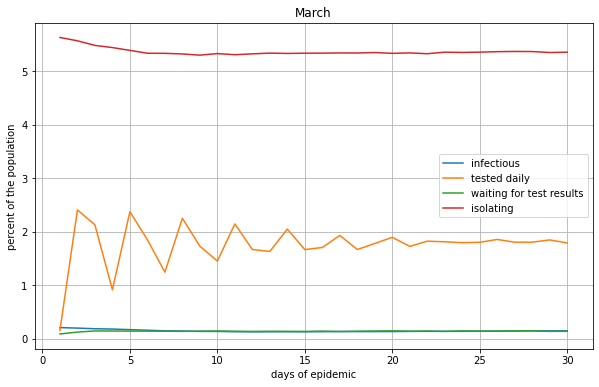

In [21]:
o_March = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

In [42]:
r = o_March.recorder.components[-1]

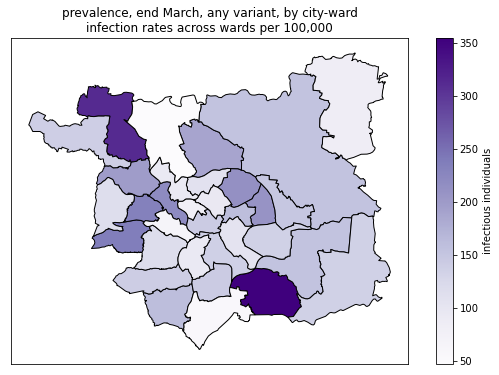

In [43]:
r.map_incidence(r.infectious, title='prevalence, end March, any variant, by city-ward', end_date=True, per_hundred_k=True)

### April (start)
1. More workplaces (such as non-essential retail) open up
2. More people brush past each other as restrictions are lifted
3. Vaccinate the over 50s
4. Next, we **seed B.1.617.2 into a single ward in Leeds**
    * (we chose Chapel Allerton for this, but we could have chosen any)

In [24]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

2021-05-24 19:30:52.314 INFO     50.0% of workplaces closed by lockdown, leaving 50043 open, of average Income Decile 4.88 (and st dev 3.13).
2021-05-24 19:30:52.534 INFO     0.0% of classrooms closed by lockdown, leaving 1621 open, of average Income Decile 4.75 (and st dev 3.08).
2021-05-24 19:30:52.577 INFO     Adding 357712 permanent contact groups
2021-05-24 19:30:52.981 INFO     Adding 158628 ephemeral contact pairs
2021-05-24 19:30:53.916 INFO     Adding 239286 contacts each within one of the 139765 buildings (contact density of 0.75)


In [25]:
from codit.population.population import seed_infection

chapel_residents = [p for p in pop.people if 'Chapel' in p.home.ward.name]
ca, = {p.home.ward.name for p in chapel_residents}

In [26]:
logging.info(f"Seeding 30 infections of B.1.617.2 in {ca}")
seed_infection(30, chapel_residents, indian_variant, lat_flow_soc)

2021-05-24 19:31:03.374 INFO     Seeding 30 infections of B.1.617.2 in Chapel Allerton


In [27]:
for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

In [28]:
pop.clear_memory()

2021-05-24 19:32:05.187 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0015
2021-05-24 19:42:57.022 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0012
2021-05-24 19:42:58.488 INFO      Realized R0 of early infections is 0.97
2021-05-24 19:42:58.489 INFO      21.6 percent of the population was infected during the epidemic


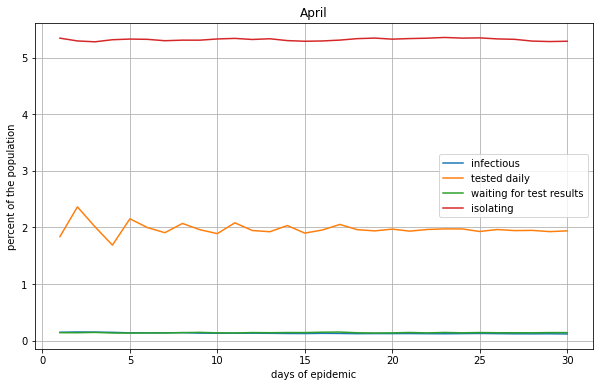

In [29]:
o_April = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

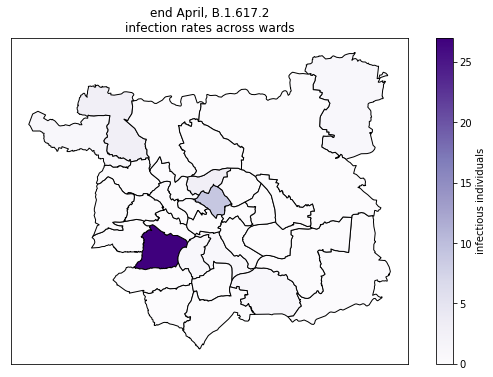

In [30]:
r = o_April.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end April, B.1.617.2', end_date=True)

* On the map, Chapel Allerton is the diamond-shaped ward of Leeds just left of centre

In [31]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of B.1.617.2:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

47 cases of B.1.617.2:
27 in Farnley & Wortley
9 in Chapel Allerton
1 in Beeston & Holbeck
3 in Moortown
1 in Wetherby
1 in Rothwell
1 in Hunslet & Riverside
1 in Guiseley & Rawdon
3 in Otley & Yeadon


### May (start)
1. Even more workplaces open up
2. More people brush past: on average 0.5 others randomly per day
3. Surge vaccination in a single ward in Leeds


In [32]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-24 19:43:04.934 INFO     33.0% of workplaces closed by lockdown, leaving 63045 open, of average Income Decile 4.91 (and st dev 3.13).
2021-05-24 19:43:05.177 INFO     0.0% of classrooms closed by lockdown, leaving 1637 open, of average Income Decile 4.78 (and st dev 3.08).
2021-05-24 19:43:05.248 INFO     Adding 370730 permanent contact groups
2021-05-24 19:43:11.866 INFO     Adding 198285 ephemeral contact pairs
2021-05-24 19:43:13.771 INFO     Adding 239650 contacts each within one of the 139765 buildings (contact density of 0.75)


In [33]:
for i, p in enumerate(chapel_residents):
    if (50 >= p.age > 18) and i % 5: # vaccinate 4 in every 5 young people
        p.vaccinate_with("AstraZeneca")

2021-05-24 19:44:19.821 INFO     Day 1, prop infected is 0.22, prop infectious is 0.0012
2021-05-24 19:56:54.396 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0011
2021-05-24 19:56:55.792 INFO      Realized R0 of early infections is 1.02
2021-05-24 19:56:55.793 INFO      22.1 percent of the population was infected during the epidemic


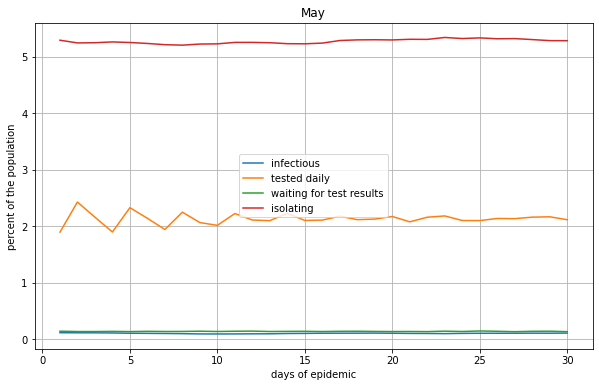

In [34]:
o_May = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")

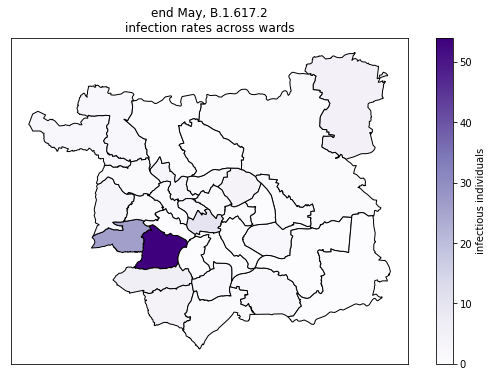

In [35]:
r = o_May.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end May, B.1.617.2', end_date=True)

In [36]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of B.1.617.2:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

135 cases of B.1.617.2:
2 in Middleton Park
2 in Guiseley & Rawdon
54 in Farnley & Wortley
26 in Pudsey
2 in Headingley & Hyde Park
1 in Horsforth
4 in Roundhay
3 in Calverley & Farsley
3 in Weetwood
10 in Little London & Woodhouse
4 in Morley South
5 in Wetherby
6 in Morley North
1 in Ardsley & Robin Hood
1 in Chapel Allerton
1 in Harewood
2 in Rothwell
2 in Temple Newsam
1 in Moortown
1 in Bramley & Stanningley
2 in Otley & Yeadon
1 in Cross Gates & Whinmoor
1 in Gipton & Harehills


### June

In [37]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (45 >= p.age > 35) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-24 19:57:12.375 INFO     33.0% of workplaces closed by lockdown, leaving 63171 open, of average Income Decile 4.92 (and st dev 3.13).
2021-05-24 19:57:12.595 INFO     0.0% of classrooms closed by lockdown, leaving 1630 open, of average Income Decile 4.77 (and st dev 3.09).
2021-05-24 19:57:12.643 INFO     Adding 370849 permanent contact groups
2021-05-24 19:57:19.498 INFO     Adding 198285 ephemeral contact pairs
2021-05-24 19:57:20.786 INFO     Adding 239243 contacts each within one of the 139765 buildings (contact density of 0.75)


2021-05-24 19:58:36.724 INFO     Day 1, prop infected is 0.22, prop infectious is 0.0011
2021-05-24 20:11:12.552 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0004
2021-05-24 20:11:14.401 INFO      Realized R0 of early infections is 0.85
2021-05-24 20:11:14.402 INFO      22.3 percent of the population was infected during the epidemic


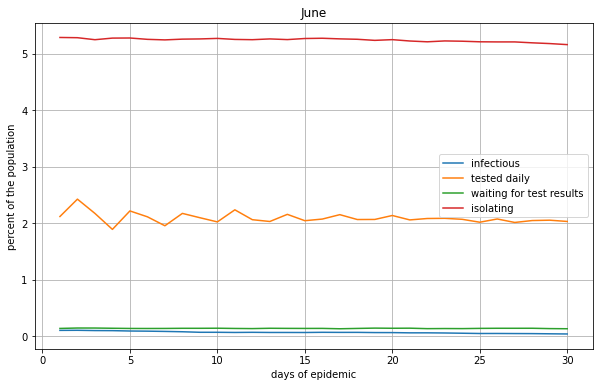

In [38]:
o_June = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_June.recorder.add_component(WardComponent(o_May))
o_June.simulate()
o_June.recorder.plot(title="June")

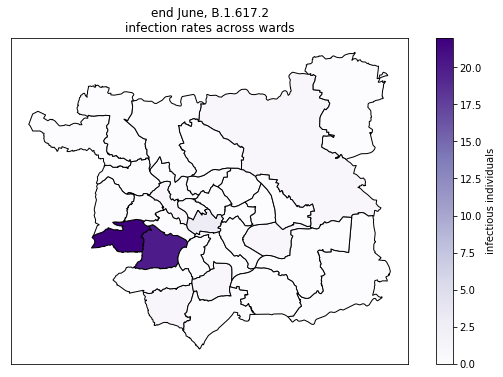

In [39]:
r = o_June.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end June, B.1.617.2', end_date=True)

In [40]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of B.1.617.2:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

50 cases of B.1.617.2:
20 in Farnley & Wortley
22 in Pudsey
1 in Kirkstall
3 in Little London & Woodhouse
1 in Middleton Park
1 in Morley South
1 in Temple Newsam
1 in Harewood


## Conclusion

1. More research needed
2. As an illustration of what can be achieved:

Always given our calibrations and assumptions, we discovered in a series of captured simulations that: 
* unfortunately, this focused vaccination at ward level was not sufficient in CODiT to stop the spread of B.1.617.2.

* Instead, the new variant tended to grow, and to jump quite often to other wards via the workplace as well as coincidental contact, often not near to Chapel Allerton at all. 

## Final remarks

We would very much value expert input on calibrations and parameter settings

The most urgent needs for this model may be in places like the Indian Subcontinent and Latin America 
* with hig infection rates and 
* competent data scientists,

who could take (freely available) Open Source CODiT & adapt it to local conditions.

There as elsewhere, we would be delighted to assist software users engaging with CODiT.